In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from lib.metrics import c_index, dynamic_c_index
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import cumulative_dynamic_auc

In [2]:
random_state = 42
torch.manual_seed(random_state)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load data


In [3]:
path = "dataset/Breast Cancer METABRIC.csv"
df = pd.read_csv(path)
df.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [4]:
patient_meta_cols = ["Patient ID", "Oncotree Code", "Cohort"]
demographic_cols = ["Age at Diagnosis", "Sex", "Inferred Menopausal State"]
cancer_characteristics_cols = [
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Neoplasm Histologic Grade",
    "Tumor Other Histologic Subtype",
    "Tumor Size",
    "Tumor Stage",
    "Primary Tumor Laterality",
]
biomarker_cols = [
    "ER Status",
    "ER status measured by IHC",
    "PR Status",
    "HER2 Status",
    "HER2 status measured by SNP6",
    "Pam50 + Claudin-low subtype",
    "3-Gene classifier subtype",
    "Integrative Cluster",
]
treatment_cols = [
    "Type of Breast Surgery",
    "Hormone Therapy",
    "Chemotherapy",
    "Radio Therapy",
]
clinical_outcome_cols = [
    "Overall Survival (Months)",
    "Overall Survival Status",
    "Patient's Vital Status",
    "Relapse Free Status (Months)",
    "Relapse Free Status",
]
clinical_metrics_cols = [
    "Lymph nodes examined positive",
    "Mutation Count",
    "Nottingham prognostic index",
]

In [5]:
df["Type of Breast Surgery"] = (
    df.groupby(["Cancer Type Detailed"])["Type of Breast Surgery"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Fill event and duration null values with the mean or the most frequent value
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Relapse Free Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status (Months)"].apply(
    lambda x: x.fillna(x.mean())
)
df["Relapse Free Status (Months)"] = grouped_df.sort_index(level=1).values
# Since the relapse free status has two classes, we have to have two level of grouping
grouped_df = df.groupby(["Cancer Type Detailed", "Relapse Free Status"])[
    "Overall Survival Status"
].apply(lambda x: x.fillna(x.mode()[0]))
df["Overall Survival Status"] = grouped_df.sort_index(level=2).values
grouped_df = df.groupby(["Cancer Type Detailed", "Overall Survival Status"])[
    "Overall Survival (Months)"
].apply(lambda x: x.fillna(x.mean()))
df["Overall Survival (Months)"] = grouped_df.sort_index(level=2).values
# Fill null values in treatment columns with mode of each cancer type detailed
# For each cancer type detailed, find the mode of each treatment column and fill null values with that mode
grouped_df = df.groupby(["Cancer Type Detailed"])["Chemotherapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Chemotherapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Hormone Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Hormone Therapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Radio Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Radio Therapy"] = grouped_df.sort_index(level=1).values
df["ER status measured by IHC"] = df["ER status measured by IHC"].fillna(
    df["ER status measured by IHC"].mode()[0]
)
grouped_df = df.groupby(["ER status measured by IHC"])["ER Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["ER Status"] = grouped_df.sort_index(level=1).values
df["HER2 status measured by SNP6"] = df["HER2 status measured by SNP6"].fillna(
    df["HER2 status measured by SNP6"].mode()[0]
)
grouped_df = df.groupby(["HER2 status measured by SNP6"])["HER2 Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["HER2 Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["PR Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["PR Status"] = grouped_df.sort_index(level=1).values
df["Pam50 + Claudin-low subtype"] = df["Pam50 + Claudin-low subtype"].fillna(
    df["Pam50 + Claudin-low subtype"].mode()[0]
)
df["3-Gene classifier subtype"] = (
    df.groupby(["Cancer Type Detailed"])["3-Gene classifier subtype"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Integrative Cluster"] = (
    df.groupby(["Cancer Type Detailed"])["Integrative Cluster"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Cohort"] = (
    df.groupby(["Cancer Type Detailed"])["Cohort"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Fill null age at diagnosis with the mean age of each cancer type detailed
df["Age at Diagnosis"] = (
    df.groupby(["Cancer Type Detailed"])["Age at Diagnosis"]
    .apply(lambda x: x.fillna(x.mean()))
    .sort_index(level=1)
    .values
)

# Fill the inferred menopausal state with the common state
df["Inferred Menopausal State"] = df["Inferred Menopausal State"].fillna(
    df["Inferred Menopausal State"].mode()[0]
)
df["Cellularity"] = (
    df.groupby(["Cancer Type Detailed"])["Cellularity"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Need to have fall back mechanism as their exists cases where all cellularity values are null for a given cancer type detailed
df["Tumor Stage"] = (
    df.groupby(["Cancer Type Detailed", "Cellularity"])["Tumor Stage"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=2)
    .values
)
df["Tumor Stage"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Stage"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
# 3 fallback levels to fill tumor size as there exists cases where all tumor size values are null for a given cancer type detailed and tumor stage
df["Tumor Size"] = (
    df.groupby(["Cancer Type Detailed", "Tumor Stage"])["Tumor Size"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=2)
    .values
)
df["Tumor Size"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Size"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
df["Tumor Size"] = df["Tumor Size"].fillna(df["Tumor Size"].median())
# 2 fallback levels to fill neoplasm histologic grade as there exists cases where all neoplasm histologic grade values are null for a given cancer type detailed
df["Neoplasm Histologic Grade"] = (
    df.groupby(["Cancer Type Detailed"])["Neoplasm Histologic Grade"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Neoplasm Histologic Grade"] = df["Neoplasm Histologic Grade"].fillna(
    df["Neoplasm Histologic Grade"].mode()[0]
)
df["Tumor Other Histologic Subtype"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Other Histologic Subtype"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Tumor Other Histologic Subtype"] = df["Tumor Other Histologic Subtype"].fillna(
    "Ductal/NST"
)
df["Primary Tumor Laterality"] = (
    df.groupby(["Cancer Type Detailed"])["Primary Tumor Laterality"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Lymph nodes examined positive"] = (
    df.groupby(["Cancer Type Detailed"])["Lymph nodes examined positive"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Lymph nodes examined positive"] = df["Lymph nodes examined positive"].fillna(
    df["Lymph nodes examined positive"].mode()[0]
)
df["Mutation Count"] = (
    df.groupby(["Cancer Type Detailed"])["Mutation Count"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Mutation Count"] = df["Mutation Count"].fillna(df["Mutation Count"].mode()[0])
df["Nottingham prognostic index"] = (
    df.groupby(["Tumor Size"])["Nottingham prognostic index"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
df["Nottingham prognostic index"] = df["Nottingham prognostic index"].fillna(
    df["Nottingham prognostic index"].median()
)
# drop patient vital status as it is redundant with overall survival status
df.drop(columns=["Patient's Vital Status", "Patient ID"], inplace=True)

/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  retur

In [6]:
numeric_cols = df._get_numeric_data().columns
categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
object_cols = [
    "Type of Breast Surgery",
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Chemotherapy",
    "Chemotherapy",
    "Pam50 + Claudin-low subtype",
    "ER status measured by IHC",
    "ER Status",
    "HER2 status measured by SNP6",
    "HER2 Status",
    "Tumor Other Histologic Subtype",
    "Hormone Therapy",
    "Inferred Menopausal State",
    "Integrative Cluster",
    "Primary Tumor Laterality",
    "Oncotree Code",
    "PR Status",
    "Radio Therapy",
    "Sex",
    "3-Gene classifier subtype",
]

for col in object_cols:
    df[col] = np.uint8(LabelEncoder().fit_transform(df[col]))

df["Overall Survival Status"] = np.uint8(
    df["Overall Survival Status"].map({"Living": 0, "Deceased": 1})
)
df["Relapse Free Status"] = np.uint8(
    df["Relapse Free Status"].map({"Not Recurred": 0, "Recurred": 1})
)

In [7]:
features = (
    demographic_cols
    + cancer_characteristics_cols
    + biomarker_cols
    + treatment_cols
    + clinical_metrics_cols
)
overall_survival_cols = ["Overall Survival (Months)", "Overall Survival Status"]
relapse_free_cols = ["Relapse Free Status (Months)", "Relapse Free Status"]

In [8]:
scikit_y = np.dtype(
    [
        ("Overall Survival Status", np.bool_),
        ("Overall Survival (Months)", np.float64),
    ]
)

In [9]:
# Assuming 'df' is your Pandas DataFrame
# 'features' are your independent variables, 'target' is your dependent variable
X = df[features]
y = df[overall_survival_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_state,
    stratify=y["Overall Survival Status"],
)

# Metabric dataset


In [10]:
class MetabricDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.features[idx]
        label = self.labels[idx]
        return data, label

# Define model


In [11]:
class BaseSurvivalClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = features
        self.categorical_cols = [
            col for col in categorical_cols if col in self.features
        ]
        self.numerical_cols = [col for col in numeric_cols if col in self.features]
        self.embeddings = nn.ModuleDict()
        for col in self.categorical_cols:
            num_unique_values = int(df[col].nunique())
            embedding_size = 8
            self.embeddings[col] = nn.Embedding(num_unique_values, embedding_size)

    def embed_with_time(self, x, t):
        embedded_cols = []
        for col in self.categorical_cols:
            # ndarray = np.array()
            embedded_col = self.embeddings[col](x[:, self.features.index(col)].long())
            # print(embedded_col.shape)
            embedded_cols.append(embedded_col)
        numerical_data = torch.stack(
            [
                torch.tensor(x[:, self.features.index(col)])
                for col in self.numerical_cols
                if col != "Overall Survival (Months)"
            ],
            dim=1,
        ).float()
        time_data = torch.reshape(t, (x.shape[0], 1)).float()

        x = torch.cat(embedded_cols + [numerical_data, time_data], dim=1)
        return x

    def embed_without_time(self, x):
        embedded_cols = []
        for col in self.categorical_cols:
            embedded_col = self.embeddings[col](x[:, self.features.index(col)].long())
            embedded_cols.append(embedded_col)
        numerical_data = torch.stack(
            [
                torch.tensor(x[:, self.features.index(col)])
                for col in self.numerical_cols
                if col != "Overall Survival (Months)"
            ],
            dim=1,
        ).float()
        x = torch.cat(embedded_cols + [numerical_data], dim=1)
        return x

    def forward(self, x):
        raise NotImplementedError("Forward method not implemented!")

In [12]:
class FullyParameterizedSurvivalModel(BaseSurvivalClass):
    def __init__(self):
        super().__init__()
        self.net_without_time = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

        self.net_with_time = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

    def forward(self, x, t):
        x_without_time = self.embed_without_time(x)
        x_with_time = self.embed_with_time(x, t)
        per_patient_hazard = self.net_without_time(x_without_time)
        baseline_hazard = self.net_with_time(x_with_time)
        hazard = baseline_hazard * per_patient_hazard
        return hazard


class CoxPHLoss(nn.Module):
    """
    Cox Proportional Hazards partial likelihood loss.
    Efficient implementation using the Breslow approximation for tied events.
    """

    def __init__(self):
        super().__init__()

    def forward(
        self, model: FullyParameterizedSurvivalModel, features, durations, events
    ):
        """
        Args:
            log_h: log hazard ratio predictions from model, shape (batch_size,)
            durations: observed time (either event or censoring time), shape (batch_size,)
            events: event indicator (1 if event, 0 if censored), shape (batch_size,)

        Returns:
            loss: negative log partial likelihood
        """
        # Sort by time
        sorted_durations, sorted_indices = torch.sort(durations)
        sorted_events = events[sorted_indices]

        # Calculate negative partial log-likelihood
        log_likelihood = 0.0

        # print(sorted_log_h.shape)

        for i in range(len(sorted_durations)):
            if sorted_events[i] == 1:  # If an event occurred
                # Risk set: all individuals still at risk at time t_i
                # (includes individual i and all individuals with longer times)
                failure_time = torch.ones(sorted_durations[i:].shape).to(device)
                failure_time *= sorted_durations[i]
                risk_set_log_h = model(
                    features[sorted_indices[i:]],
                    failure_time,
                )

                # Log partial likelihood contribution
                # log h_i - log(sum of exp(log h_j) for j in risk set)
                log_likelihood += risk_set_log_h[0] - torch.logsumexp(
                    risk_set_log_h, dim=0
                )

        return -log_likelihood  # Return negative for minimization

In [13]:
model = FullyParameterizedSurvivalModel().to(device)
loss_fn = CoxPHLoss().to(device)

In [14]:
base_model = BaseSurvivalClass()

In [15]:
learning_rate = 0.0001
batch_size = 64
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
train_dataset = MetabricDataset(X_train.to_numpy(), y_train.to_numpy())
test_dataset = MetabricDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    accum_loss = 0
    for feature, label in dataloader:
        feature = feature.to(device)
        y = label.to(device)

        loss = loss_fn(model, feature, y[:, 0], y[:, 1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accum_loss += loss.item()
    return accum_loss / len(dataloader)

In [17]:
train_loop(train_loader, model, loss_fn, optimizer)

/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


117.301589012146

In [18]:
c_indices = []
average_losses = []
for t in range(epochs):
    epoch_loss = train_loop(train_loader, model, loss_fn, optimizer)
    average_losses.append(epoch_loss)
    print(f"Epoch {t+1} loss: {epoch_loss:>7f} ")
    scheduler.step()
print("Done!")

/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


Epoch 1 loss: 116.845753 
Epoch 2 loss: 116.493211 
Epoch 3 loss: 116.129655 
Epoch 4 loss: 115.279492 
Epoch 5 loss: 114.839480 
Epoch 6 loss: 114.224335 
Epoch 7 loss: 113.868997 
Epoch 8 loss: 113.220522 
Epoch 9 loss: 113.038827 
Epoch 10 loss: 112.982035 
Epoch 11 loss: 112.633080 
Epoch 12 loss: 112.766949 
Epoch 13 loss: 112.536527 
Epoch 14 loss: 112.423141 
Epoch 15 loss: 112.069686 
Epoch 16 loss: 112.109685 
Epoch 17 loss: 112.126545 
Epoch 18 loss: 112.131516 
Epoch 19 loss: 111.739110 
Epoch 20 loss: 111.682732 
Epoch 21 loss: 111.590658 
Epoch 22 loss: 111.381716 
Epoch 23 loss: 111.239711 
Epoch 24 loss: 111.335933 
Epoch 25 loss: 111.228997 
Epoch 26 loss: 111.369949 
Epoch 27 loss: 111.208534 
Epoch 28 loss: 110.856994 
Epoch 29 loss: 111.128904 
Epoch 30 loss: 110.752682 
Epoch 31 loss: 110.743439 
Epoch 32 loss: 110.828558 
Epoch 33 loss: 110.795869 
Epoch 34 loss: 110.595647 
Epoch 35 loss: 110.730073 
Epoch 36 loss: 110.474928 
Epoch 37 loss: 110.485715 
Epoch 38 l

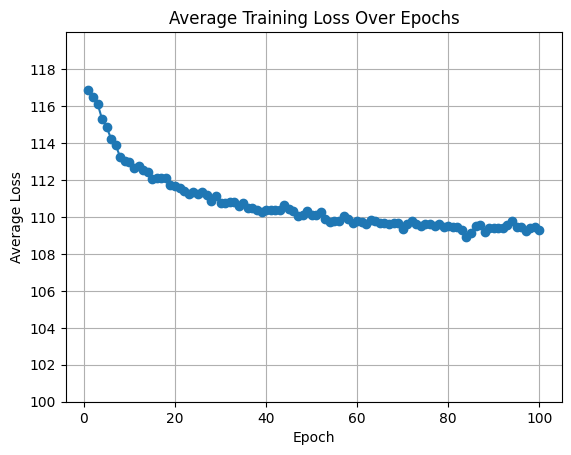

In [19]:
plt.plot(range(1, epochs + 1), average_losses, marker="o")
plt.title("Average Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.ylim(ymin=100, ymax=120)
plt.yticks(np.arange(100, 120, 2))
plt.grid()

In [32]:
# After each epoch, evaluate C-index
va_times = np.arange(0.1, 300, 12)
model.eval()
risks_all = np.array([])
with torch.no_grad():
    for feature, label in test_loader:
        feature = feature.to(device)
        y = label.to(device)
        for t in va_times:
            time_tensor = torch.ones(feature.shape[0]).to(device) * t
            risks = model(feature, time_tensor).cpu().numpy().flatten()
            risks_all = np.concatenate((risks_all, risks))
    risks_all = risks_all.reshape(-1, len(va_times))
print(risks_all.shape)

(502, 25)


/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


In [34]:
# After each epoch, evaluate C-index
va_times = np.arange(0.1, 300, 12)
model.eval()
risks_all = np.array([])
with torch.no_grad():
    for feature, label in test_loader:
        feature = feature.to(device)
        y = label.to(device)
        for t in va_times:
            time_intervals = np.arange(0.1, t + 1, 1)
            accumulated_risks = np.zeros(feature.shape[0])  # (num_samples,)
            for ti in time_intervals:
                time_tensor = torch.ones(feature.shape[0]).to(device) * ti
                risks = model(feature, time_tensor).cpu().numpy().flatten()
                accumulated_risks += risks
            # time_tensor = torch.ones(feature.shape[0]).to(device) * t
            # risks = model(feature, time_tensor).cpu().numpy().flatten()
            risks_all = np.concatenate((risks_all, accumulated_risks))
    risks_all = risks_all.reshape(-1, len(va_times))
print(risks_all.shape)

/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_84768/89827663.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


(502, 25)


# Random Survival Forest

In [35]:
# Assuming 'df' is your Pandas DataFrame
# 'features' are your independent variables, 'target' is your dependent variable
X = df[features]
y = df[overall_survival_cols]
y = df[overall_survival_cols[::-1]]
y = y.to_records(
    index=False,
    column_dtypes={
        "Overall Survival Status": np.bool_,
        "Overall Survival (Months)": np.float64,
    },
)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_state,
    stratify=y["Overall Survival Status"],
)

In [36]:
rsf = RandomSurvivalForest(n_estimators=200, min_samples_leaf=10, random_state=42)

In [37]:
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, n_estimators=200, random_state=42)

In [38]:
va_times = np.arange(0.1, 300, 12)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.vstack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)
custom_auc, custom_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risks_all, va_times
)

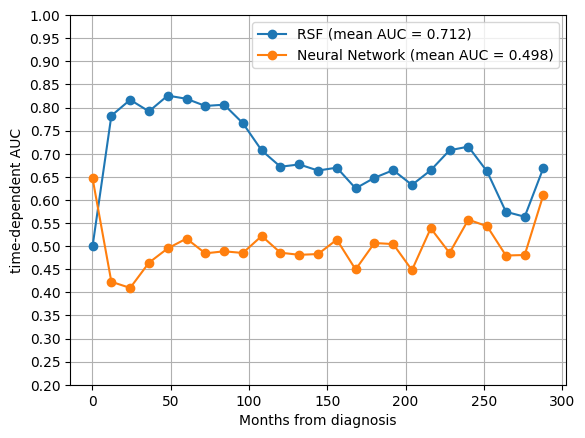

In [39]:
plt.plot(va_times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.plot(
    va_times,
    custom_auc,
    "o-",
    label=f"Neural Network (mean AUC = {custom_mean_auc:.3f})",
)
plt.xlabel("Months from diagnosis")
plt.yticks(np.arange(0.2, 1.05, 0.05))
plt.ylabel("time-dependent AUC")
plt.legend(loc="upper right")
plt.grid(True)